In [1]:
from ipynb.fs.full.Population import Population
from ipynb.fs.full.Simulation import Simulation
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output
import time
import cv2
import os

In [2]:
def distanceAtIndex(driver, index):
    return [np.sum(driver[0][0:index] * np.arange(index, 0, -1) - driver[1][0:index] * np.arange(index, 0, -1)), np.sum(driver[2][0:index] * np.arange(index, 0, -1) - driver[3][0:index] * np.arange(index, 0, -1))]

In [3]:
def calc_fitness(agent):
    d1 = distanceAtIndex(agent, round(agent.shape[1]/5))
    d2 = distanceAtIndex(agent, 2*round(agent.shape[1]/5))
    d3 = distanceAtIndex(agent, 3*round(agent.shape[1]/5))
    d4 = distanceAtIndex(agent, 4*round(agent.shape[1]/5))
    d5 = distanceAtIndex(agent, 5*round(agent.shape[1]/5))
    #if ((d1[0] < 0) or d2[1] < 0 or d3[0] < 0 or
    
    return ((d1[0] - abs(d1[1])) + (d2[1] - abs(d2[0])) + (0 - d3[0] - abs(d3[1])) + (0 - d4[1] - abs(d4[0]))) - (abs(d5[0]) + abs(d5[1]))

In [47]:
n_epochs = 2000
mutation_values = np.zeros(shape=n_epochs)
z = 10
for i in range(z):
    mutation_values[round(n_epochs/z)*i:] = (((z-2)/z) ** i)*(0.98 ** np.arange(0,n_epochs-(round(n_epochs/z)*i)))/40
    #mutation_values[round(n_epochs/z)*i:] = (0.98 ** np.arange(0,n_epochs-(round(n_epochs/z)*i)))/100
#mutation_values += (0.999 ** np.arange(0,n_epochs)/100)
#mutation_values += 0.02

Text(0.5, 1.0, 'Mutation Rate')

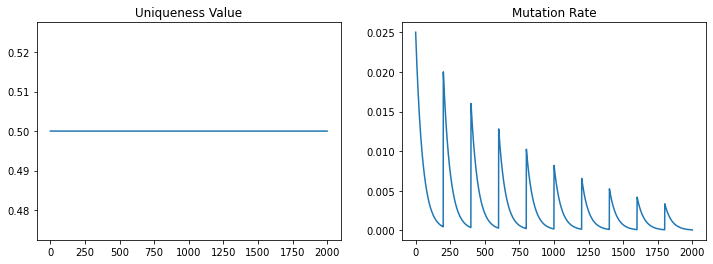

In [48]:
n_agents = 100
agent_length=500
period = 10
Unique_max = 0.5
Mutation_max = 0.02
x = np.arange(0, n_epochs, 1)
uniqueness_value = np.ones(shape=n_epochs) * Unique_max
#uniqueness_value = signal.square(2 * np.pi * x / period, duty=0.5) * Unique_max/3 + Unique_max
#mutation_values = signal.square(2 * np.pi * x / period, duty=0.5) * Mutation_max/3 + Mutation_max
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x, uniqueness_value)
ax[0].set_title("Uniqueness Value")
ax[1].plot(x, mutation_values)
ax[1].set_title("Mutation Rate")

In [49]:
sim = Simulation(calc_fitness)
testPop = Population(agent_length=agent_length, num_agents=n_agents, bounds=(0,1000), num_genes=50)
#testPop.define_visualization_function(plot_agents)
#testPop.display()

In [50]:
completed = 0
startTime = time.time()
for i in range(n_epochs):
    #gen_mutation_rate = 1 #sine(i, period=125, max=0.01, offset = -25)
    #uniqueness_value = exponentialsine(i, period=250, exponent=4, max=1.25, offset = 100)

    nextGen, fitness, diversity = sim.next_generation(testPop, mutation_rate=mutation_values[i], value_diversity = uniqueness_value[i], show_fitness = True, show_diversity = True)
    testPop.next_generation(nextGen, fitness, diversity)

    #if completed%round(n_epochs/1000) == 0:
        #testPop.save_img(str(testPop.epoch).zfill(5))

    clear_output(wait=True)
    completed += 1
    if i%10 == 0:
        print(f'{i}/{n_epochs} completed:\t|{"="*round(40 * i/n_epochs)}|{"-" * round(40 * (n_epochs-i)/n_epochs)}|\t{round(((time.time() - startTime)/completed) * (n_epochs-completed), 1)}s remaining')

print('Completed!')

Completed!


Text(0.5, 1.0, 'Best Solution found vs epoch')

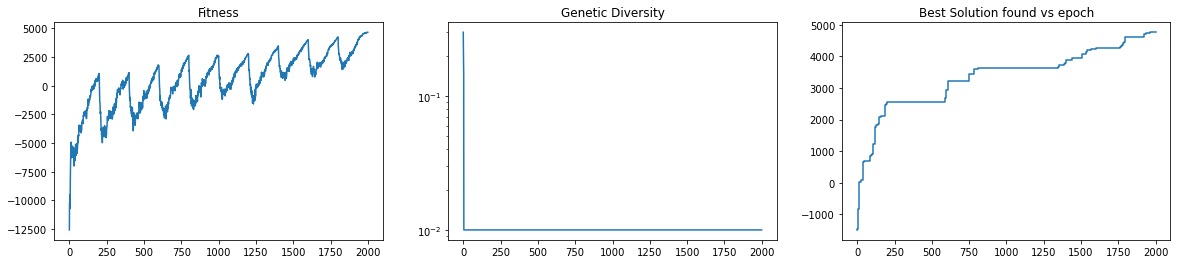

In [51]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(np.arange(0, len(testPop.fitness_history)), testPop.fitness_history)
ax[0].set_title('Fitness')
ax[1].plot(np.arange(0, len(testPop.diversity_history)), testPop.diversity_history)
ax[1].set_yscale('log')
ax[1].set_title('Genetic Diversity')
#ax[2].step(np.array(sim.best_agents, dtype=object)[:,2], np.array(sim.best_agents, dtype=object)[:,1])
ax[2].step(np.append(np.array(sim.best_agents, dtype=object)[:,2], len(testPop.diversity_history)), np.append(np.array(sim.best_agents, dtype=object)[:,1], max(np.array(sim.best_agents, dtype=object)[:,1])))
ax[2].set_title('Best Solution found vs epoch')
#print(f'Final diversity score: {testPop.diversity_history[-1]}')

In [27]:
def sim_driver(driver):
    vel = np.array([0,0])
    pos = np.array([0,0])
    posh = np.copy(pos)
    
    for i in range(len(driver[0])):
        vel[0] += driver[0,i]
        vel[0] -= driver[1,i]
        vel[1] += driver[2,i]
        vel[1] -= driver[3,i]
        pos += vel

        posh = np.vstack((posh, pos))
    return posh[1:]

def plot_point(p):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.scatter(p[0], p[1], alpha=1)
    return fig

def save_driver(posh):
    for i, p in enumerate(posh):
        fig = plot_point(p)
        fig.savefig(f'Output/{str(i).zfill(5)}.jpg')
        plt.close(fig)

def save_graph_population(population, best, autozoom=True):
    paths = np.array([sim_driver(driver) for driver in population])
    bestpath = sim_driver(best)
    for i, point in enumerate(bestpath):
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.scatter(paths[:,i,0], paths[:,i,1], alpha=0.6)
        ax.scatter(point[0], point[1], color='orange')
        if not autozoom:
            maxv = max(np.max(abs(paths)), np.max(abs(bestpath)))
            ax.set_xlim(-maxv-2, maxv+2)
            ax.set_ylim(-maxv-2, maxv+2)
            
        fig.savefig(f'Output/{str(i).zfill(5)}.jpg')
        plt.close(fig)

In [28]:
save_graph_population(testPop.agents, sim.best_agents[-1][0], autozoom=False)

In [29]:
image_folder = './Output'
video_name = 'Output.mp4'

images = [img for img in os.listdir(image_folder)]
#images.remove('.ipynb_checkpoints')

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 60, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

print(f'Finished converting {len(images)} images into video')

Finished converting 500 images into video
